In [309]:
# import packages

import pandas as pd
import numpy as np
import csv
import math
import plotly
import dash
import json
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn import datasets

In [310]:
# read in datasets

vdem = pd.read_csv('V-Dem-CY-Full+Others-v14.csv', encoding= 'utf-8')
bti = pd.read_csv('free-fair-elections-bti.csv', quoting=csv.QUOTE_NONE, encoding= 'utf-8')
fiw = pd.read_excel('Country_and_Territory_Ratings_and_Statuses_FIW_1973-2024.xlsx', sheet_name = 'Country Ratings, Statuses ', skiprows = 2)
fiw_years = pd.read_excel('Country_and_Territory_Ratings_and_Statuses_FIW_1973-2024.xlsx', sheet_name = 'Country Ratings, Statuses ', skiprows=1, nrows=1, header = None)
wrp = pd.read_csv('mutated_NWR.csv', quoting=csv.QUOTE_NONE, encoding= 'utf-8')

/var/folders/rd/8m4_zzhs0pn_c_576285lzcm0000gp/T/ipykernel_21547/658557787.py:3: DtypeWarning:

Columns (364,365,366,399,415,804,836,837,924,1240,1257,1486,3094,3168,3169,3341,3342,3344,3345,3347,3350,3352) have mixed types. Specify dtype option on import or set low_memory=False.



In [311]:
# Remove uneccesary quotation marks from the vdem and wrp datasets

vdem = vdem.replace('"', '', regex=True)
new_headers_v = []
for header in vdem.columns: 
    header = header.strip('"') 
    new_headers_v.append(header)
vdem.columns = new_headers_v
new_headers_w = []
for header in wrp.columns: 
    header = header.strip('"') 
    new_headers_w.append(header)
wrp.columns = new_headers_w

In [312]:
# Reshape the FIW dataset to align with the format of the other datasets

PR = [col for col in fiw.columns if col.startswith('PR')]
CL = [col for col in fiw.columns if col.startswith('CL')]
Status = [col for col in fiw.columns if col.startswith('Status')]
fiw_r = pd.lreshape(fiw, {'PR':PR, 'CL':CL, 'Status':Status})

In [313]:
# Align country names to match among all datasets in the appropriate years

country_rename = {
    "Burma/Myanmar": "Myanmar (Burma)",
    "Myanmar": "Myanmar (Burma)",
    "Republic of Vietnam": "South Vietnam",
    "Vietnam, S.": "South Vietnam",
    "Vietnam, N.": "North Vietnam", # add code that says if its before a certain year, change some Vietnams to North Vietnam
    "Yemen, S.": "South Yemen",
    "Yemen, N.": "North Yemen", # add code that says if its before a certain year, change some Yemens to North Yemen
    "Republic of the Congo": "Congo (Brazzaville)",
    "Congo": "Congo (Brazzaville)",
    "Democratic Republic of the Congo": "Congo (Kinshasa)",
    "Germany, W.": "West Germany", # add code that says if its before a certain year, change some Germanies to West Germany
    "Germany, E.": "East Germany", 
    "German Democratic Republic": "East Germany",
    "Czechia": "Czech Republic", # add code that says if its before a certain year, change it to Czechoslovakia
    "United States": "United States of America",
    "Cote d'Ivoire": "Ivory Coast",
    "Cabo Verde": "Cape Verde",
    "Türkiye": "Turkey",
    "East Timor": "Timor-Leste",
    "The Gambia": "Gambia"
}

vdem["country_name"] = vdem["country_name"].replace(country_rename) 
bti["Entity"] = bti["Entity"].replace(country_rename) 
fiw_r["Country"] = fiw_r["Country"].replace(country_rename) 


for i in range(len(vdem)):
    if (vdem.loc[i,'country_name'] == 'Vietnam') and (1945 < vdem.loc[i,'year'] <= 1976):
        vdem.loc[i,'country_name'] = 'North Vietnam'
    # fix about yemen
    if (vdem.loc[i,'country_name'] == 'Yemen') and (1918 < vdem.loc[i,'year'] <= 1990):
        vdem.loc[i,'country_name'] = 'North Yemen'
    if (vdem.loc[i,'country_name'] == 'Germany') and (1949 < vdem.loc[i,'year'] <= 1990):
        vdem.loc[i,'country_name'] = 'West Germany'
    if (vdem.loc[i,'country_name'] == 'Czech Republic') and (vdem.loc[i,'year'] < 1993):
        vdem.loc[i,'country_name'] = 'Czechoslovakia'

In [314]:
# Merge vdem and bti datasets

data = vdem.merge(bti[['Entity', 'Year', 'Free and fair elections']], left_on = ['country_name', 'year'], right_on = ['Entity', 'Year'], how = 'left')

In [315]:
# Insert Year column back into FIW dataset

fiw_r.insert(1, 'Year', '')

In [316]:
# Reshape FIW Years dataset to prepare for merging

fiw_years = fiw_years.transpose()
fiw_years.columns = fiw_years.iloc[0]  
fiw_years = fiw_years[1:]

In [317]:
# Remove NAs from FIW years dataset

fiw_years.dropna(inplace=True)

In [318]:
# Insert FIW years data back into reshaped FIW dataset

mult = 1
i = 0
while i < len(fiw_r):
    while i < mult*205:
        fiw_r.loc[i, 'Year'] = fiw_years.iloc[mult-1, 0]
        i += 1
    mult += 1

In [319]:
# Merge FIW dataset into master dataset

# maybe dont left join, fiw has data on smaller countries that v-dem doesnt
data = data.merge(fiw_r, left_on = ['country_name', 'year'], right_on = ['Country', 'Year'], how = 'left')

In [320]:
# Merge WRP dataset into master dataset

data = data.merge(wrp, left_on = ['COWcode', 'year'], right_on = ['state', 'year'], how = 'left')

In [321]:
# Write rows in wrp that do not match with the master dataset to csv for analysis

#non_matching_rows = data[data['name'].isna()]
#print(non_matching_rows)
#with open('non_matching_rows.txt', 'w+', newline='') as file:
#   non_matching_rows.to_csv('non_matching_rows.txt', sep = '\t', index=False)

In [322]:
# Drop unecessary/unused columns

data = data.drop(columns=data.loc[:, 'chrstprot':'pop'].columns)
data = data.drop(columns=data.loc[:, 'datatype':'sourcecode'].columns)
data = data.drop(columns=data.loc[:, 'historical_date':'gap_index'].columns)
data = data.drop(columns=['Entity', 'Year_x', 'Country', 'Year_y', 'state', 'name'])

In [323]:
# Rename columns

data = data.rename(columns={'v2x_civlib':'CivLib', 'v2x_clphy':'Violence', 'v2x_clpol':'PolLib', 'v2x_freexp_altinf':'FreeExpress', 'v2xcl_rol':'LawEqual', 'v2xeg_eqprotec':'EqProtect', 'v2x_corr':'Corrupt_vdem', 'v2x_execorr':'Ecorrupt', 'v2x_pubcorr':'Pubcorrupt', 'v2x_rule':'RuleLaw', 'v2xcl_acjst':'Justice', 'v2xcl_prpty':'Property', 'v2juhcind':'CourtIndep'})

In [324]:
# Rename countries to align with historical basempas

for i in range(len(data)):
    if (data.loc[i,'country_name'] == 'Russia'):
        if (data.loc[i,'year'] <= 1917):
            data.loc[i,'country_name'] = 'Russian Empire'
        elif (data.loc[i,'year'] <= 1991):
            data.loc[i,'country_name'] = 'USSR'
    if (data.loc[i,'country_name'] == 'United States of America') and (data.loc[i,'year'] >= 1914):
        data.loc[i,'country_name'] = 'United States'
    if (data.loc[i,'country_name'] == 'United Kingdom') and (data.loc[i,'year'] < 1938):
        data.loc[i,'country_name'] = 'United Kingdom of Great Britain and Ireland'
    if (data.loc[i,'country_name'] == 'Brazil') and (data.loc[i,'year'] < 1914):
        data.loc[i,'country_name'] = 'Kingdom of Brazil'
    if (data.loc[i,'country_name'] == 'Germany') and (data.loc[i,'year'] >= 1914 and data.loc[i,'year'] < 1920):
        data.loc[i,'country_name'] = 'German Empire'
#    if (data.loc[i,'country_name'] == 'East Germany'):
#            data.loc[i,'country_name'] = 'Germany (Soviet)'
    if (data.loc[i,'country_name'] == 'North Korea'):
        if (data.loc[i,'year'] in range (1945, 1960)):
            data.loc[i,'country_name'] = 'Korea (USSR)'
        if (data.loc[i,'year'] >= 1960):
            data.loc[i,'country_name'] = 'Korea, Democratic People\'s Republic of'
    if (data.loc[i,'country_name'] == 'South Korea'):
        if (data.loc[i,'year'] in range (1945, 1960)):
            data.loc[i,'country_name'] = 'Korea (USA)'
        if (data.loc[i,'year'] >= 1960):
            data.loc[i,'country_name'] = 'Korea, Republic of'
    if (data.loc[i,'country_name'] == 'India') and (data.loc[i,'year'] < 1945):
        data.loc[i,'country_name'] = 'British Raj'
    if (data.loc[i,'country_name'] == 'Japan') and (data.loc[i,'year'] >= 1945 and data.loc[i,'year'] < 1960):
        data.loc[i,'country_name'] = 'Japan (USA)'
    if (data.loc[i,'country_name'] == 'Madagascar') and (data.loc[i,'year'] >= 1945 and data.loc[i,'year'] < 1960):
        data.loc[i,'country_name'] = 'Madagascar (France)'
    if (data.loc[i,'country_name'] == 'Mozambique') and (data.loc[i,'year'] >= 1945 and data.loc[i,'year'] < 1960):
        data.loc[i,'country_name'] = 'Mozambique (Portugal)'
    if (data.loc[i,'country_name'] == 'Bosnia and Herzegovina') and (data.loc[i,'year'] >= 1918 and data.loc[i,'year'] < 1994):
        data.loc[i,'country_name'] = 'Yugoslavia'
    if (data.loc[i,'country_name'] == 'Croatia') and (data.loc[i,'year'] >= 1918 and data.loc[i,'year'] < 1994):
        data.loc[i,'country_name'] = 'Yugoslavia'
    if (data.loc[i,'country_name'] == 'Macedonia') and (data.loc[i,'year'] >= 1918 and data.loc[i,'year'] < 1994):
        data.loc[i,'country_name'] = 'Yugoslavia'
    if (data.loc[i,'country_name'] == 'Serbia') and (data.loc[i,'year'] >= 1918 and data.loc[i,'year'] < 1994):
        data.loc[i,'country_name'] = 'Yugoslavia'
    if (data.loc[i,'country_name'] == 'Slovenia') and (data.loc[i,'year'] >= 1918 and data.loc[i,'year'] < 1994):
        data.loc[i,'country_name'] = 'Yugoslavia'
    if (data.loc[i,'country_name'] == 'Kosovo') and (data.loc[i,'year'] >= 1918 and data.loc[i,'year'] < 1994):
        data.loc[i,'country_name'] = 'Yugoslavia'
#    if (data.loc[i,'country_name'] == 'Congo (Brazzaville)') and (data.loc[i,'year'] >= 1938 and data.loc[i,'year'] < 1945):
#        data.loc[i,'country_name'] = 'Congo (France)'
#    if (data.loc[i,'country_name'] == 'Congo (Brazzaville)') and (data.loc[i,'year'] >= 1945):
#        data.loc[i,'country_name'] = 'Republic of the Congo'
    if (data.loc[i,'country_name'] == 'Congo (Kinshasa)') and (data.loc[i,'year'] >= 1938):
        data.loc[i,'country_name'] = 'Congo'
    if (data.loc[i,'country_name'] == 'Congo (Brazzaville)') and (imp_cn.loc[i,'year'] >= 1958):
        data.loc[i,'country_name'] = 'Zaire'
#    if (data.loc[i,'country_name'] == 'Congo (Kinshasa)') and (data.loc[i,'year'] >= 1945):
#        data.loc[i,'country_name'] = 'Democratic Republic of the Congo'
    if (data.loc[i,'country_name'] == 'Belarus') and (data.loc[i,'year'] >= 1994):
        data.loc[i,'country_name'] = 'Byelarus'
    if (data.loc[i,'country_name'] == 'Myanmar (Burma)') and (data.loc[i,'year'] >= 1994):
        data.loc[i,'country_name'] = 'Burma'
    if (data.loc[i,'country_name'] == 'Myanmar (Burma)') and (data.loc[i,'year'] >= 1960 and data.loc[i,'year'] < 1994):
        data.loc[i,'country_name'] = 'Burma'
    if (data.loc[i,'country_name'] == 'North Macedonia') and (data.loc[i,'year'] >= 1994):
        data.loc[i,'country_name'] = 'Macedonia'
    if (data.loc[i,'country_name'] == 'Italy') and (data.loc[i,'year'] >= 1994):
        data.loc[i,'country_name'] = 'Italy'
    if (data.loc[i,'country_name'] == 'Italy') and (data.loc[i,'year'] < 1994):
        data.loc[i,'country_name'] = 'Italy'
    if (data.loc[i,'country_name'] == 'Tanzania'):
        data.loc[i,'country_name'] = 'Tanzania, United Republic of'
    if (data.loc[i,'country_name'] == 'North Yemen'):
        data.loc[i,'country_name'] = 'Yemen'
    if (data.loc[i,'country_name'] == 'East Germany' and data.loc[i,'year'] >= 1949 and data.loc[i,'year'] < 1960):
        data.loc[i,'country_name'] = 'Germany (Soviet)'
    if (data.loc[i,'country_name'] == 'West Germany' and data.loc[i,'year'] >= 1949 and data.loc[i,'year'] < 1960):
        data.loc[i,'country_name'] = 'Germany (UK)'
    if (data.loc[i,'country_name'] == 'North Vietnam' and data.loc[i,'year'] < 1976):
        data.loc[i,'country_name'] = 'Vietnam'
    if (data.loc[i,'country_name'] == 'South Vietnam' and data.loc[i,'year'] < 1976):
        data.loc[i,'country_name'] = 'Cochin China'
    if (data.loc[i,'country_name'] == 'Angola' and data.loc[i,'year'] >= 1945 and data.loc[i,'year'] < 1960):
        data.loc[i,'country_name'] = 'Angola (Portugal)'
    if (data.loc[i,'country_name'] == 'Zimbabwe' and data.loc[i,'year'] >= 1923 and data.loc[i,'year'] < 1960):
        data.loc[i,'country_name'] = 'Rhodesia'
    if (data.loc[i,'country_name'] == 'Zambia' and data.loc[i,'year'] >= 1900 and data.loc[i,'year'] < 1960):
        data.loc[i,'country_name'] = 'Northern Rhodesia'
    if (data.loc[i,'country_name'] == 'Libya' and data.loc[i,'year'] >= 1945 and data.loc[i,'year'] < 1960):
        data.loc[i,'country_name'] = 'Cyraneica (UK Lybia)'
    if (data.loc[i,'country_name'] == 'Ghana' and data.loc[i,'year'] >= 1945 and data.loc[i,'year'] < 1960):
        data.loc[i,'country_name'] = 'Gold Coast'
#    if (data.loc[i,'country_name'] == 'Cameroon' and data.loc[i,'year'] >= 1945 and data.loc[i,'year'] < 1960):
#        data.loc[i,'country_name'] = 'Southern Cameroon'

In [325]:
# Write master dataset to csv

data = data[data['year'] >= 1945]
data.reset_index(drop=True, inplace=True)
with open('capstone_data.csv', 'w+', newline='') as file:
   data.to_csv('capstone_data.csv')

In [326]:
# Import imputed csv with names

imp_cn = pd.read_csv('imputed_cn.csv', encoding= 'utf-8')
imp_cn = imp_cn.rename(columns={'rescaled': 'Freedom', 'e_gdppc':'GDP per Capita', 'v2eldonate':'Disclosure of Campaign Donations', 'v2elpubfin':'Public Campaign Finance', 'v2elembaut':'EMB Autonomy', 'v2elrgpwr':'Regional Offices Relative Power', 'v2ellocpwr':'Local Offices Relative Power', 'v2psbars':'Barriers to Parties', 'v2exrescon':'Executive Respects Constitution', 'v2cltort':'Freedom From Torture', 'v2caautmob':'Mobilization for Autocracy'})

In [327]:
# map visualization new/updated with non-imputed data

from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import geopandas as gpd

app = Dash(__name__)

def load_geojson(year):
    with open(f'world_{year}.geojson') as f: 
        return json.load(f)

app.layout = html.Div([
    html.H4('Political Indicators'),
    html.P("Select a indicator:"),
    dcc.RadioItems(
        id='indicator', 
#        options=["CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice", "Property", "CourtIndep", "nonreligpct", "e_fh_status"], 
        options=[{"label": "Civil Liberties", "value":"CivLib"}, {"label": "Freedom from Political Killings and Torture", "value": "Violence"}, {"label": "Political Liberties", "value": "PolLib"}, {"label": "Freedom of Expression and Alternate Sources of Information", "value": "FreeExpress"}, {"label": "Equality Before the Law and Individual Liberty", "value": "LawEqual"}, {"label": "Equal Protections of Rights and Freedoms", "value": "EqProtect"}, {"label": "Political Corruption", "value": "Corrupt_vdem"}, {"label": "Executive Branch Corruption", "value": "Ecorrupt"}, {"label": "Public Sector Corruption", "value": "Pubcorrupt"}, {"label": "Rule of Law: Impartial, Transparent, and Equally Enforced Laws", "value": "RuleLaw"}, {"label": "Secure and Effective Access to Justice", "value": "Justice"}, {"label": "Secure and Effective Access to Justice", "value": "Justice"}, {"label": "Property Rights", "value": "Property"}, {"label": "High Court Independence from Governmental Position", "value": "CourtIndep"}, {"label": "Percent of Citizens without Religous Affiliation", "value": "nonreligpct"}, {"label": "Freedom Status (Most to Least Free)", "value": "e_fh_status"}],
        value="CivLib",
        inline=True
    ),
    dcc.Slider(
        id='year',
        min=1945,  
        max=2020,
        step=1,
        value=1945,  
        marks={year: str(year) for year in range(1945, 2021, 5)},
        tooltip={"placement": "bottom", "always_visible": True}
    ),
    dcc.Graph(id="graph"),
])

#update_map_years = np.array([1900, 1914, 1920, 1930, 1938, 1945, 1960, 1994, 2000, 2010])
update_map_years = np.array([1945, 1960, 1992, 1994, 2000, 2010])
@app.callback(
    Output("graph", "figure"), 
    [Input("indicator", "value"), Input("year", "value")])
def display_choropleth(indicator, year): 
    if (year in update_map_years):
        geo = load_geojson(year)
    else:
        i = len(update_map_years) - 1
        while i >= 0 and update_map_years[i] > year:
             i -= 1               
        geo = load_geojson(update_map_years[i])
    df = data
    df_year = df[df['year'] == year]
    fig = go.Figure(go.Choropleth(
        z=df_year[indicator],  
        hoverinfo='location+z',  
        locations=df_year['country_name'],  #country_text_id #country_name #        locationmode='country names',  #ISO-3 #country names
        featureidkey='properties.NAME',
        geojson=geo,
        colorbar_title=indicator,  
    ))
    fig.update_geos(fitbounds="locations", projection_type="natural earth")
    fig.update_layout(
        margin={"r":0, "t":0, "l":0, "b":0},
        title=f'{indicator} for Year {year}'
    )
    return fig


app.run_server(debug=True)

In [55]:
# Rename countries to align with historical basemaps (imputed_cn version)

for i in range(len(imp_cn)):
    if (imp_cn.loc[i,'country_name'] == 'Russia'):
        if (imp_cn.loc[i,'year'] <= 1917):
            imp_cn.loc[i,'country_name'] = 'Russian Empire'
        elif (imp_cn.loc[i,'year'] <= 1991):
            imp_cn.loc[i,'country_name'] = 'USSR'
    if (imp_cn.loc[i,'country_name'] == 'United States of America') and (imp_cn.loc[i,'year'] >= 1914):
        imp_cn.loc[i,'country_name'] = 'United States'
    if (imp_cn.loc[i,'country_name'] == 'Belarus') and (imp_cn.loc[i,'year'] >= 1992):
        imp_cn.loc[i,'country_name'] = 'Byelarus'
    if (imp_cn.loc[i,'country_name'] == 'Myanmar (Burma)') and (imp_cn.loc[i,'year'] >= 1994):
        imp_cn.loc[i,'country_name'] = 'Burma'
    if (imp_cn.loc[i,'country_name'] == 'Myanmar (Burma)') and (imp_cn.loc[i,'year'] >= 1960 and imp_cn.loc[i,'year'] < 1994):
        imp_cn.loc[i,'country_name'] = 'Myanmar'
    if (imp_cn.loc[i,'country_name'] == 'North Macedonia') and (imp_cn.loc[i,'year'] >= 1994):
        imp_cn.loc[i,'country_name'] = 'Macedonia'
    if (imp_cn.loc[i,'country_name'] == 'Italy') and (imp_cn.loc[i,'year'] >= 1994):
        imp_cn.loc[i,'country_name'] = 'Italy'
    if (imp_cn.loc[i,'country_name'] == 'Italy') and (imp_cn.loc[i,'year'] < 1994):
        imp_cn.loc[i,'country_name'] = 'Italy'
    if (imp_cn.loc[i,'country_name'] == 'Tanzania'):
        imp_cn.loc[i,'country_name'] = 'Tanzania, United Republic of'
    if (imp_cn.loc[i,'country_name'] == 'North Yemen'):
        imp_cn.loc[i,'country_name'] = 'Yemen'
    if (imp_cn.loc[i,'country_name'] == 'North Korea'):
        if (imp_cn.loc[i,'year'] in range (1945, 1960)):
            imp_cn.loc[i,'country_name'] = 'Korea (USSR)'
        if (imp_cn.loc[i,'year'] >= 1960):
            imp_cn.loc[i,'country_name'] = 'Korea, Democratic People\'s Republic of'
    if (imp_cn.loc[i,'country_name'] == 'South Korea'):
        if (imp_cn.loc[i,'year'] in range (1945, 1960)):
            imp_cn.loc[i,'country_name'] = 'Korea (USA)'
        if (imp_cn.loc[i,'year'] >= 1960):
            imp_cn.loc[i,'country_name'] = 'Korea, Republic of'
    if (imp_cn.loc[i,'country_name'] == 'Bosnia and Herzegovina') and (imp_cn.loc[i,'year'] >= 1918 and imp_cn.loc[i,'year'] < 1992):
        imp_cn.loc[i,'country_name'] = 'Yugoslavia'
    if (imp_cn.loc[i,'country_name'] == 'Croatia') and (imp_cn.loc[i,'year'] >= 1918 and imp_cn.loc[i,'year'] < 1992):
        imp_cn.loc[i,'country_name'] = 'Yugoslavia'
    if (imp_cn.loc[i,'country_name'] == 'Macedonia') and (imp_cn.loc[i,'year'] >= 1918 and imp_cn.loc[i,'year'] < 1992):
        imp_cn.loc[i,'country_name'] = 'Yugoslavia'
    if (imp_cn.loc[i,'country_name'] == 'Serbia') and (imp_cn.loc[i,'year'] >= 1918 and imp_cn.loc[i,'year'] < 1992):
        imp_cn.loc[i,'country_name'] = 'Yugoslavia'
    if (imp_cn.loc[i,'country_name'] == 'Slovenia') and (imp_cn.loc[i,'year'] >= 1918 and imp_cn.loc[i,'year'] < 1992):
        imp_cn.loc[i,'country_name'] = 'Yugoslavia'
    if (imp_cn.loc[i,'country_name'] == 'Kosovo') and (imp_cn.loc[i,'year'] >= 1918 and imp_cn.loc[i,'year'] < 1992):
        imp_cn.loc[i,'country_name'] = 'Yugoslavia'
    if (imp_cn.loc[i,'country_name'] == 'Congo (Kinshasa)') and (imp_cn.loc[i,'year'] >= 1938):
        imp_cn.loc[i,'country_name'] = 'Congo'
    if (imp_cn.loc[i,'country_name'] == 'Türkiye'):
        imp_cn.loc[i,'country_name'] = 'Turkey'
    if (imp_cn.loc[i,'country_name'] == 'Democratic Republic of the Congo') and (imp_cn.loc[i,'year'] >= 1958):
        imp_cn.loc[i,'country_name'] = 'Zaire'
    if (imp_cn.loc[i,'country_name'] == 'German Democratic Republic') and (imp_cn.loc[i,'year'] > 1949):
        imp_cn.loc[i,'country_name'] = 'East Germany'
    if (imp_cn.loc[i,'country_name'] == 'Germany') and (1949 < imp_cn.loc[i,'year'] <= 1990):
        imp_cn.loc[i,'country_name'] = 'West Germany'

In [59]:
# map visualization new/updated with imputed data

from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import geopandas as gpd

app = Dash(__name__)

def load_geojson(year):
    with open(f'world_{year}.geojson') as f: 
        return json.load(f)

app.layout = html.Div([
    html.H4('Political Indicators'),
    html.P("Select a indicator:"),
    dcc.RadioItems(
        id='indicator', 
        options=["GDP per Capita", "Disclosure of Campaign Donations", "Public Campaign Finance", "EMB Autonomy", "Regional Offices Relative Power", "Local Offices Relative Power", "Barriers to Parties", "Executive Respects Constitution", "Freedom From Torture", "Mobilization for Autocracy", "Freedom"], # e_fh_status
#        options=[{"label": "GDP", "value":"GDP per Capita"}, {"label": "Disclosure", "value": "Disclosure of Campaign Donations"}],
        value="Freedom",
        inline=True
    ),
    dcc.Slider(
        id='year',
        min=1972,  
        max=2020,
        step=1,
        value=1972,  
        marks={year: str(year) for year in range(1972, 2021, 5)},
        tooltip={"placement": "bottom", "always_visible": True}
    ),
    dcc.Graph(id="graph"),
])

#update_map_years = np.array([1900, 1914, 1920, 1930, 1938, 1945, 1960, 1994, 2000, 2010])
update_map_years = np.array([1960, 1992, 1994, 2000, 2010])
@app.callback(
    Output("graph", "figure"), 
    [Input("indicator", "value"), Input("year", "value")])
def display_choropleth(indicator, year): 
    if (year in update_map_years):
        geo = load_geojson(year)
    else:
        i = len(update_map_years) - 1
        while i >= 0 and update_map_years[i] > year:
             i -= 1               
        geo = load_geojson(update_map_years[i])
#    df = data
    df = imp_cn
    df_year = df[df['year'] == year]
    fig = go.Figure(go.Choropleth(
        z=df_year[indicator],  
        hoverinfo='location+z',  
#        hover_name = 'location',
#        hover_data = ['z'],
        locations=df_year['country_name'],  #country_text_id #country_name #        locationmode='country names',  #ISO-3 #country names
        featureidkey='properties.NAME',
        geojson=geo,
        colorbar_title=indicator,  
    ))
    fig.update_geos(fitbounds="locations", projection_type="natural earth")
    fig.update_layout(
        margin={"r":0, "t":0, "l":0, "b":0},
        title=f'{indicator} for Year {year}'
    )
    return fig


app.run_server(debug=True)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
/var/folders/rd/8m4_zzhs0pn_c_576285lzcm0000gp/T/ipykernel_9403/2042376592.py in display_choropleth(indicator='Freedom')
     24 #    df = data 
     25     df = imp_cn
---> 26     fig = px.choropleth(
        fig = undefined
        global px.choropleth = <function choropleth at 0x7f8cd2a71820>
        df =        Unnamed: 0      e_pop  GDP per Capita  Freedom  year  \
0               1   1318.104           1.752      4.5  1972   
1               2   1360.303           1.706      6.5  1973   
2               3   1398.612           1.699      6.5  1974   
3               4   1422.666           1.702      6.5  1975   
4               5   1453.850           1.707      6.5  1976   
...           ...        ...             ...      ...   ...   
53131       53132    804.296           8.623      6.0  2019   
53132       53133    383.651      

Dropdown(description='country_name:', options=('Mexico', 'Suriname', 'Sweden', 'Switzerland', 'Ghana', 'South …

Dropdown(description='variable:', options=('CivLib', 'Violence', 'PolLib', 'FreeExpress', 'LawEqual', 'EqProte…

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



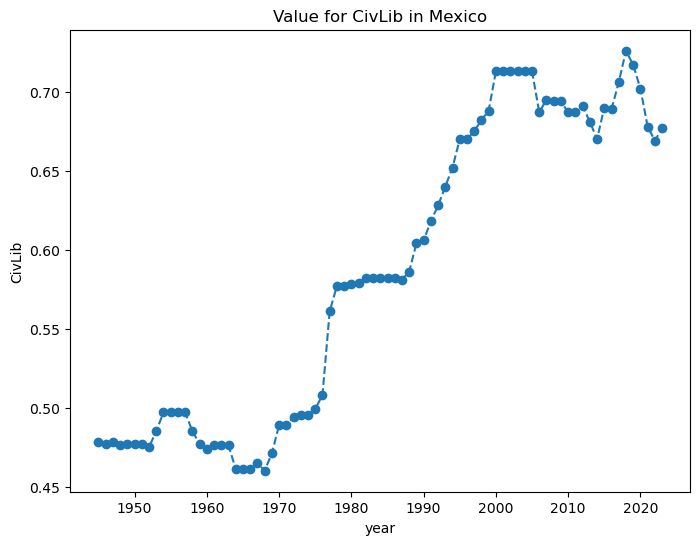

In [24]:
# display graph over time for country using dropdown (old)

df = data

country_dropdown = widgets.Dropdown(options=df['country_name'].unique(), description='country_name:')
variables=["CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice", "Property", "CourtIndep", "nonreligpct", "e_fh_status"]
variable_dropdown = widgets.Dropdown(options=variables, description='variable:')

def update_chart(change):
    country = country_dropdown.value
    variable = variable_dropdown.value
    filtered_df = df[(df['country_name'] == country)] # & (df['year'] == year)
    plt.figure(figsize=(8, 6))
#    plt.line(filtered_df['year'], filtered_df['CivLib'])
    plt.plot(filtered_df['year'], filtered_df[variable], linestyle='--', marker='o')
    plt.xlabel('year')
    plt.ylabel(variable)
    plt.title(f'Value for {variable} in {country}')
    plt.show()

#update_chart((country_dropdown.value, variable_dropdown.value))

country_dropdown.observe(update_chart, names='value')
variable_dropdown.observe(update_chart, names='value')

display(country_dropdown, variable_dropdown)

update_chart(None)

In [25]:
# display graph over time for country using dropdown (new, multi-selection for countries))

df = data

app = Dash(__name__)

country_options = [{'label': country, 'value': country} for country in df['country_name'].unique()]
variable_options = [{'label': variable, 'value': variable} for variable in ["CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice", "Property", "CourtIndep", "nonreligpct", "e_fh_status"]]

#country_dropdown = widgets.Dropdown(options=df['country_name'].unique(), description='Country:')
#variables = ["CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice", "Property", "CourtIndep", "nonreligpct", "e_fh_status"]
#variable_dropdown = widgets.Dropdown(options=variables, description='Variable:')

app.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id='country-dropdown',
            options=country_options,
            value=country_options[0]['value'],
            multi=True
        ),
    ], style={'width': '48%', 'display': 'inline-block'}),
    html.Div([
        dcc.Dropdown(
            id='variable-dropdown',
            options=variable_options,
            value=variable_options[0]['value']
        ),
    ], style={'width': '48%', 'display': 'inline-block'}),
    dcc.Graph(id='graph-court')

])

@app.callback(
    Output('graph-court', 'figure'),
    [Input('country-dropdown', 'value'),
     Input('variable-dropdown', 'value')]
)

def update_chart(countries, variable):
#    country = country_dropdown.value
#    variable = variable_dropdown.value
#    filtered_df = df[df['country_name'] == country]
    filtered_df = df[df['country_name'].isin(countries)]
    fig = go.Figure()
    for country in countries:
        country_data = filtered_df[filtered_df['country_name'] == country]
        fig.add_trace(go.Scatter(
            x=country_data['year'],
            y=country_data[variable],
            mode='lines',  
            name=country, 
            line=dict(dash='dash')  
    ))
#    fig.add_trace(go.Scatter(
#        x=filtered_df['year'], 
#        y=filtered_df[variable], 
#        mode='lines', #lines+markers
#        name=variable, 
#        line=dict(dash='dash')
#    ))
    fig.update_layout(
        title=f'{variable} in Selected Countries',
        xaxis_title='Year',
        yaxis_title=variable,
        template='plotly_white'
    )
#    country_dropdown.observe(update_chart, names='value')
#    variable_dropdown.observe(update_chart, names='value')
#    display(country_dropdown, variable_dropdown)
#    fig.show()
    return fig

#update_chart(None)

if __name__ == '__main__':
    app.run_server(debug=True)

In [61]:
# display graph over time for country using dropdown (new, multi-selection for variables))

df = data

app = Dash(__name__)

country_options = [{'label': country, 'value': country} for country in df['country_name'].unique()]
variable_options = [{'label': variable, 'value': variable} for variable in ["CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice", "Property", "CourtIndep", "nonreligpct", "e_fh_status"]]

#country_dropdown = widgets.Dropdown(options=df['country_name'].unique(), description='Country:')
#variables = ["CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice", "Property", "CourtIndep", "nonreligpct", "e_fh_status"]
#variable_dropdown = widgets.Dropdown(options=variables, description='Variable:')

app.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id='country-dropdown',
            options=country_options,
            value=country_options[0]['value']
        ),
    ], style={'width': '48%', 'display': 'inline-block'}),
    html.Div([
        dcc.Dropdown(
            id='variable-dropdown',
            options=variable_options,
            value=variable_options[0]['value'],
            multi = True
        ),
    ], style={'width': '48%', 'display': 'inline-block'}),
    dcc.Graph(id='graph-court')

])

@app.callback(
    Output('graph-court', 'figure'),
    [Input('country-dropdown', 'value'),
     Input('variable-dropdown', 'value')]
)

def update_chart(country, variables):
#    country = country_dropdown.value
#    variable = variable_dropdown.value
    filtered_df = df[df['country_name'] == country]
    fig = go.Figure()
    for variable in variables:
        country_data = filtered_df[filtered_df['country_name'] == country]
        fig.add_trace(go.Scatter(
            x=country_data['year'],
            y=country_data[variable],
            mode='lines',  
            name=f"{variable}", 
            line=dict(dash='dash')  
    ))
#    fig.add_trace(go.Scatter(
#        x=filtered_df['year'], 
#        y=filtered_df[variable], 
#        mode='lines', #lines+markers
#        name=variable, 
#        line=dict(dash='dash')
#    ))
    fig.update_layout(
        title=f'Political Indicators in {country}',
        xaxis_title='Year',
        yaxis_title='Variables',
        template='plotly_white'
    )
    return fig

#update_chart(None)

if __name__ == '__main__':
    app.run_server(debug=True)

In [27]:
# setting up data (X, y) for classification
# experimented adding nonreligionpct which brought scores down, removed property which helped a bit

free = ['F', 'NF', 'PF']
together = data.loc[:, ("Status", "CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice", "Property")]
together = together.dropna()
together.reset_index(inplace=True)
for i in range(len(together)):
    if together.loc[i, "Status"] not in free:
        together = together.drop([i])
together = together.dropna()
together.reset_index(drop=True, inplace=True)
X = together.loc[:, ("CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice", "Property")]
y = together["Status"]

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
~/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py in get_loc(
    self=Index(['country_name', 'country_text_id', 'count...eliabilevel'],
      dtype='object', length=4633),
    key='C'
)
   3790         try:
-> 3791             return self._engine.get_loc(casted_key)
        self._engine.get_loc = <built-in method get_loc of pandas._libs.index.ObjectEngine object at 0x7f8cf2f09040>
        casted_key = 'C'
   3792         except KeyError as err:

index.pyx in pandas._libs.index.IndexEngine.get_loc()

index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'C'

The above exception was the direct cause of the following 

In [28]:
# Performing classification

scaler = StandardScaler()
estimators=[('lr', LogisticRegression(max_iter = 50000, class_weight='balanced')), ('mlp', MLPClassifier(max_iter = 50000, solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)), ('svc', SVC(probability=True, max_iter = 50000, class_weight='balanced'))]
ensemble = VotingClassifier(estimators, voting='soft')
model = Pipeline([('standardize', scaler),
                    ('ensemble', ensemble)])
parameters = {'C':('ensemble', 'rbf'), 'C': [1, 10]}
kfold = StratifiedKFold(n_splits=10)
predictions = cross_val_predict(model, X, y, cv=kfold)
target_names = ['NF', 'PF', 'F']
classification_report(y, predictions, target_names=target_names)

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
~/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexes/base.py in get_loc(
    self=Index(['country_name', 'country_text_id', 'count...eliabilevel'],
      dtype='object', length=4633),
    key='C'
)
   3790         try:
-> 3791             return self._engine.get_loc(casted_key)
        self._engine.get_loc = <built-in method get_loc of pandas._libs.index.ObjectEngine object at 0x7f8cf2f09040>
        casted_key = 'C'
   3792         except KeyError as err:

index.pyx in pandas._libs.index.IndexEngine.get_loc()

index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'C'

The above exception was the direct cause of the following 

KeyboardInterrupt: 

In [ ]:
# classification set up (probably not necessary to re-do, will probably delete)

estimators=[('lr', LogisticRegression(max_iter = 50000, class_weight='balanced')), ('mlp', MLPClassifier(max_iter = 50000, solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)), ('svc', SVC(probability=True, max_iter = 50000, class_weight='balanced'))]
ensemble = VotingClassifier(estimators, voting='soft')
model = Pipeline([('standardize', scaler),
                    ('ensemble', ensemble)])
parameters = {'C':('ensemble', 'rbf'), 'C': [1, 10]}
kfold = StratifiedKFold(n_splits=10)
#predictions = cross_val_predict(model, X, y, cv=kfold)
#target_names = ['NF', 'PF', 'F']
#classification_report(y, predictions, target_names=target_names)

In [ ]:
# same as first classification testing but with property variable added in [two set ups used to compare adding and removing different variables for optimal results]

together = data.loc[:, ("Status", "CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice", "Property", "CourtIndep")]
together = together.dropna()
together.reset_index(inplace=True)
for i in range(len(together)):
    if together.loc[i, "Status"] not in free:
        together = together.drop([i])
together = together.dropna()
together.reset_index(drop=True, inplace=True)
X = together.loc[:, ("CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice", "Property", "CourtIndep")]
y = together["Status"]
predictions = cross_val_predict(model, X, y, cv=kfold)
target_names = ['NF', 'PF', 'F']
classification_report(y, predictions, target_names=target_names)

In [ ]:
# setting up data for linear regression to predicted political rights and checking r2

together = data.loc[:, ("e_fh_pr", "CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice", "Property")]
together = together.dropna()
X = together.loc[:, ("CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice")]
y = together["e_fh_pr"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
lr = LinearRegression()
model = Pipeline([('standardize', scaler),
                    ('lr', lr)])
parameters = {'C':('lr', 'rbf'), 'C': [1, 10]}
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
r2_score(y_test, y_predict)

In [ ]:
# setting up data for linear regression to predict civil liberties and checking r2

together = data.loc[:, ("e_fh_rol", "CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice", "Property")]
together = together.dropna()
X = together.loc[:, ("CivLib", "Violence", "PolLib", "FreeExpress", "LawEqual", "EqProtect", "Corrupt_vdem", "Ecorrupt", "Pubcorrupt", "RuleLaw", "Justice")]
y = together["e_fh_rol"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
lr = LinearRegression()
model = Pipeline([('standardize', scaler),
                    ('lr', lr)])
parameters = {'C':('lr', 'rbf'), 'C': [1, 10]}
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
r2_score(y_test, y_predict)

In [ ]:
#read in imputed data
#imp = pd.read_csv('finaldataset.csv', encoding= 'utf-8')
#imp = pd.read_csv('singleaggregateddataset.csv', encoding= 'utf-8')
imp = pd.read_csv('imputed.csv', encoding= 'utf-8')

In [ ]:
# Set up X,y according to imputed dataset

features = ["e_gdppc", "v2eldonate", "v2elpubfin", "v2elembaut", "v2elrgpwr", 
          "v2ellocpwr", "v2psbars", "v2exrescon", "v2cltort", "v2caautmob"]
together = imp.loc[:, ("rescaled", "e_gdppc", "v2eldonate", "v2elpubfin", "v2elembaut", "v2elrgpwr", "v2ellocpwr", "v2psbars", "v2exrescon", "v2cltort", "v2caautmob")]
X = features
#y = imp["Free and fair elections"]
y = imp["rescaled"]

In [ ]:
# Continue to set up X,y according to imputed dataset

together = together.dropna()
X = together.loc[:, ("e_gdppc", "v2eldonate", "v2elpubfin", "v2elembaut", "v2elrgpwr", "v2ellocpwr", "v2psbars", "v2exrescon", "v2cltort", "v2caautmob")]
#y = together["Free and fair elections"]
y = together["rescaled"]

In [ ]:
# linear regression testing

#lr = LogisticRegression(class_weight='balanced', max_iter = 500)
#estimators=[('lr', LogisticRegression(max_iter = 10000, class_weight='balanced')), ('mlp', MLPClassifier(max_iter = 10000, solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)), ('svc', SVC(probability=True, max_iter = 10000, class_weight='balanced'))]
#ensemble = VotingClassifier(estimators, voting='soft')
#model = Pipeline([('standardize', scaler),
#                    ('ensemble', ensemble)])
#parameters = {'C':('ensemble', 'rbf'), 'C': [1, 10]}
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
lr = LinearRegression()
model = Pipeline([('standardize', scaler),
                    ('lr', lr)])
parameters = {'C':('lr', 'rbf'), 'C': [1, 10]}
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
r2_score(y_test, y_predict)

In [ ]:
# change from numbers to strings for classification
# change from numbers to not free/partially free/free for classification

#y = y.reset_index(drop=True)
#for i in range(len(y)):
#    if y[i] <= 2.5:
#        y[i] = 'Not Free'
#    elif y[i] <= 5:
#        y[i] = 'Partially Free'
#    else:
#        y[i] = 'Free'

y = y.reset_index(drop=True)
for i in range(len(y)):
    if y[i] < 1.5:
        y[i] = 'Most Free'
    elif y[i] < 2.5:
        y[i] = 'Mostly Free'
    elif y[i] < 3.5:
        y[i] = 'Somewhat Free'
    elif y[i] < 4.5:
        y[i] = 'Slightly Free'
    elif y[i] < 5.5:
        y[i] = 'Somewhat Not Free'
    elif y[i] < 6.5:
        y[i] = 'Mostly Not Free'
    else:
        y[i] = 'Not Free'

In [ ]:
# classification

estimators=[('lr', LogisticRegression(max_iter = 50000, class_weight='balanced')), ('mlp', MLPClassifier(max_iter = 50000, solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)), ('svc', SVC(probability=True, max_iter = 50000, class_weight='balanced'))]
ensemble = VotingClassifier(estimators, voting='soft')
model = Pipeline([('standardize', scaler),
                    ('ensemble', ensemble)])
parameters = {'C':('ensemble', 'rbf'), 'C': [1, 10]}
kfold = StratifiedKFold(n_splits=10)
predictions = cross_val_predict(model, X, y, cv=kfold)
#target_names = ['Not Free', 'Partially Free', 'Free']
target_names = ['Most Free', 'Mostly Free', 'Somehwat Free', 'Slightly Free', 'Somewhat Not Free', 'Mostly Not Free', 'Not Free']
classification_report(y, predictions, target_names=target_names)

#model.fit(X_train, y_train)
#y_predict = model.predict(X_test)
#r2_score(y_test, y_predict)

In [ ]:
# k means testing

kmeans = KMeans(n_clusters=7, random_state=42) 
kmeans.fit(X)
kmeans.cluster_centers_
kmeans.inertia_
labels = kmeans.labels_
#for i in range(len(labels)):
#    if labels[i] == 0:
#        labels[i] = 'Not Free'
#    if labels[i] == 1:
#        labels[i] = 'Partially Free'
#    if labels[i] == 2:
#        labels[i] = 'Free'

# check how many of the samples were correctly clustered (e.g. whats in each cluster matches up)
sklearn.metrics.adjusted_rand_score(y, labels)

In [ ]:
# more cluster testing (incomplete so may not run right)

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = ['b', 'g', 'r']
print(colors)
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)

plt.title('number of clusters: %d' % n_clusters_)
plt.show()

sc = metrics.silhouette_score(X, labels)
print("Silhouette Coefficient:%0.2f" % sc)
ari = adjusted_rand_score(y, labels)
print("Adjusted Rand Index: %0.2f" % ari)

In [ ]:
# Load dataset
# Replace 'imp.csv' with the actual dataset file path
df = imp

# Define features and target
features = ["e_gdppc", "v2eldonate", "v2elpubfin", "v2elembaut", "v2elrgpwr", "v2ellocpwr", "v2psbars", "v2exrescon", "v2cltort", "v2caautmob"]
target = "rescaled"

# Drop rows with missing values
df = df.dropna(subset=features + [target])

# Train a model
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# Function to filter dataset based on selected country and year
def filter_data(country, year):
    filtered = df[(df['country_name'] == country) & (df['year'] == year)]
    return filtered

# Function to predict rescaled score based on inputs
def predict_rescaled(feature_values):
    feature_array = np.array([feature_values]).reshape(1, -1)
    return model.predict(feature_array)[0]

# Interactive function
def simulate(country, year, **kwargs):
    data = filter_data(country, year)
    
    if data.empty:
        display("No data available for the selected country and year.")
        return
    
    original_rescaled = data[target].values[0] if target in data.columns else None
    
    # Predict rescaled score based on user inputs
    feature_values = [kwargs[feature] for feature in features]
    predicted_rescaled = predict_rescaled(feature_values)
    
    display(f"Original Rescaled Score: {original_rescaled}")
    display(f"Predicted Rescaled Score: {predicted_rescaled}")

# Dropdowns for country and year
country_dropdown = widgets.Dropdown(options=df['country_name'].unique(), description='Country')
year_dropdown = widgets.IntSlider(min=df['year'].min(), max=df['year'].max(), step=1, description='Year')

# Sliders for feature adjustments
def create_feature_sliders(country, year):
    data = filter_data(country, year)
    sliders = {}
    for feature in features:
        default_value = data[feature].values[0] if not data.empty and feature in data.columns and pd.notna(data[feature].values[0]) else 0.0
        sliders[feature] = widgets.FloatSlider(min=-1, max=1, step=0.1, value=default_value, description=feature)
    return sliders

def update_sliders(*args):
    global feature_sliders
    feature_sliders = create_feature_sliders(country_dropdown.value, year_dropdown.value)
    display(widgets.VBox(list(feature_sliders.values())))
    update_simulation(country_dropdown.value, year_dropdown.value, **{f: s.value for f, s in feature_sliders.items()})

feature_sliders = create_feature_sliders(country_dropdown.value, year_dropdown.value)

def update_simulation(country, year, **kwargs):
    simulate(country, year, **kwargs)

In [ ]:
# Observe changes in country and year
year_dropdown.observe(update_sliders, names='value')
country_dropdown.observe(update_sliders, names='value')

#display(widgets.VBox([country_dropdown, year_dropdown] + list(feature_sliders.values())))
widgets.interactive(update_simulation, country=country_dropdown, year=year_dropdown, **feature_sliders)